In [1]:
from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive
import pandas as pd

# Query exoplanet data from the 'Planetary Systems (PS)' table
exoplanets = NasaExoplanetArchive.query_criteria(
    table="PSCompPars",  # The new Planetary Systems (PS) table
    select="pl_name, ra, dec, sy_dist, pl_orbincl, pl_orbsmax, st_mass, st_rad",
    where="sy_dist IS NOT NULL"  # Filter to get systems with known distances
)

# Convert the result to a pandas DataFrame for easier handling
df_exoplanets = exoplanets.to_pandas()

# Display the first few rows of the data
print(df_exoplanets.head())


/tmp/ipykernel_512028/2898371398.py:1: DeprecationWarning: the ``nasa_exoplanet_archive`` module has been moved to astroquery.ipac.nexsci.nasa_exoplanet_archive, please update your imports.
  from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive


        pl_name          ra        dec    sy_dist  pl_orbincl  pl_orbsmax  \
0  Kepler-276 c  293.568197  39.036312  1144.8600       86.92      0.1994   
1  Kepler-829 b  282.332831  42.463813  1073.7600       89.82      0.0678   
2  Kepler-477 b  288.067445  42.355305   367.0000       87.75      0.0911   
3    TOI-1260 c  157.144071  65.854199    73.5977       87.97      0.0657   
4   HD 149143 b  248.212671   2.084455    73.2801         NaN      0.0530   

   st_mass  st_rad  sky_coord.ra  sky_coord.dec  
0     1.10    1.03    293.568197      39.036312  
1     0.98    0.97    282.332831      42.463813  
2     0.87    0.79    288.067445      42.355305  
3     0.68    0.67    157.144071      65.854199  
4     1.20    1.44    248.212671       2.084455  


In [2]:
from astroquery.gaia import Gaia
import pandas as pd

# Query a region of the sky or specific magnitude range
job = Gaia.launch_job("SELECT TOP 10000 source_id, ra, dec, parallax, phot_g_mean_mag, bp_rp FROM gaiadr3.gaia_source WHERE phot_g_mean_mag < 15")
result = job.get_results()

# Convert to DataFrame
df = result.to_pandas()
print(df.head())


             SOURCE_ID          ra        dec   parallax  phot_g_mean_mag  \
0  1576683529448755328  193.508178  55.959785        NaN         1.731607   
1  6560604777055249536  332.059078 -46.961617        NaN         1.773280   
2  1510374147844219904  206.884327  49.313202        NaN         1.881019   
3  3377166289889430656   95.740374  22.513099        NaN         1.881368   
4   418551920284673408   10.127242  56.537189  14.090976         1.942524   

      bp_rp  
0  0.338367  
1  0.252056  
2  0.165524  
3  1.878384  
4  1.143484  


In [3]:
import numpy as np
from astropy.coordinates import SkyCoord, Distance, SphericalRepresentation, CartesianRepresentation
import astropy.units as u


def compute_star_properties_from_exoplanet(df_gaia, exoplanet):
    exoplanet_coord = SkyCoord(
        ra=exoplanet["ra"] * u.deg,
        dec=exoplanet["dec"] * u.deg,
        distance=Distance(value=exoplanet["sy_dist"], unit=u.pc),
    )

    star_coord = SkyCoord(
        ra=df_gaia["ra"].values * u.deg,
        dec=df_gaia["dec"].values * u.deg,
        distance=Distance(parallax=df_gaia["parallax"].values * u.mas, allow_negative=True),
    )

    star_relative_position = star_coord.transform_to('icrs').represent_as(CartesianRepresentation) - exoplanet_coord.transform_to('icrs').represent_as(CartesianRepresentation)
    star_from_exoplanet = star_relative_position.represent_as(SphericalRepresentation)


    # Calculate the translated distance
    new_dist = star_from_exoplanet.distance.to(u.parsec).value

    # Extract new RA and Dec
    new_ra = star_from_exoplanet.lon.deg
    new_dec = star_from_exoplanet.lat.deg
    absolute_magnitude = (
        df_gaia["phot_g_mean_mag"] + 5 - 5 * np.log10(1000 / df_gaia["parallax"])
    )
    apparent_magnitude = (
        absolute_magnitude - 5 + 5 * np.log10(new_dist)
    )

    df_gaia["new_ra"] = new_ra
    df_gaia["new_dec"] = new_dec
    df_gaia["apparent_magnitude"] = apparent_magnitude
        # rows.append(row)
    return df_gaia


In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_smth(ra_arr, dec_arr, mag_arr, bp_rp_arr):


    # Create a figure
    plt.figure(figsize=(10, 6))

    # Using Mollweide projection for RA/DEC
    ra_rad = np.radians(ra_arr - 180)  # Center the map at RA = 180°
    dec_rad = np.radians(dec_arr)

    # Adjust star sizes with exponential scaling
    size = np.exp(4 - mag_arr)  # Exponential scaling for sizes

    # Use the 'bp_rp' values to map colors of stars (use colormap that transitions from blue to red)
    cmap = plt.get_cmap('coolwarm')  # A colormap going from blue to red
    norm = plt.Normalize(vmin=-5, vmax=7)  # Normalize 'bp_rp' values for color mapping

    # Create the subplot with Mollweide projection
    ax = plt.subplot(111, projection="mollweide")

    # Set the face color of the projection (ellipse region) to deep blue
    ax.set_facecolor('#000033')

    # Plot stars using scatter
    sc = ax.scatter(ra_rad, dec_rad, s=size, c=bp_rp_arr, cmap=cmap, norm=norm, alpha=0.75)

    # Add labels and title
    ax.set_xlabel('Right Ascension (degrees)', color='white')
    ax.set_ylabel('Declination (degrees)', color='white')
    ax.set_title('Star Map from Gaia Data (Mollweide Projection)', color='white')

    # Colorbar for the magnitude
    # cb = plt.colorbar(sc)
    # cb.set_label('Magnitude (G)', color='white')

    # Adjust colorbar ticks and labels to white
    # cb.ax.yaxis.set_tick_params(color='white')
    # plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color='white')

    # Adjust axis labels and ticks to white to contrast with the dark projection background
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.tick_params(axis='both', colors='white')

    # Show the plot
    plt.show()


In [5]:
df_exoplanets[df_exoplanets["pl_name"].str.contains("Proxima")]


,pl_name,ra,dec,sy_dist,pl_orbincl,pl_orbsmax,st_mass,st_rad,sky_coord.ra,sky_coord.dec
3501,Proxima Cen b,217.393466,-62.676182,1.30119,NaN,0.04856,0.12,0.14,217.393466,-62.676182


In [6]:
exoplanet = df_exoplanets.iloc[5737]
# 3501 - proxima centauri b


/home/fort/projects/exosky/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


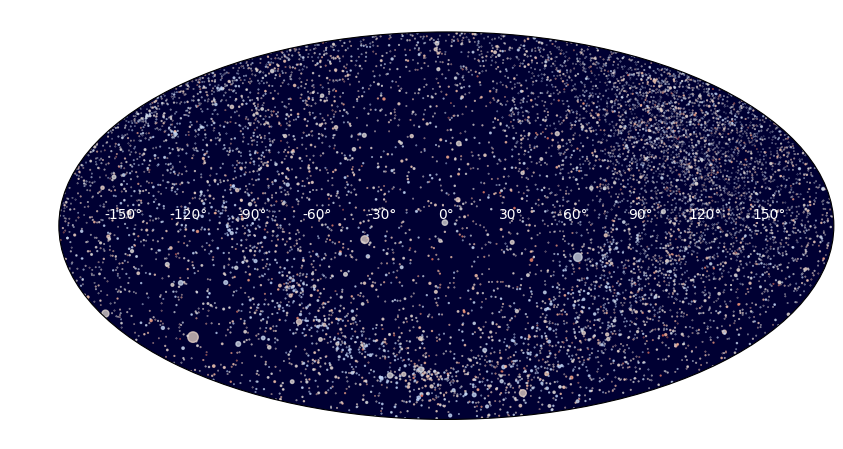

In [7]:
df = compute_star_properties_from_exoplanet(df, df_exoplanets.iloc[5737])
plot_smth(df["new_ra"], df["new_dec"], df["apparent_magnitude"], df["bp_rp"])



/home/fort/projects/exosky/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


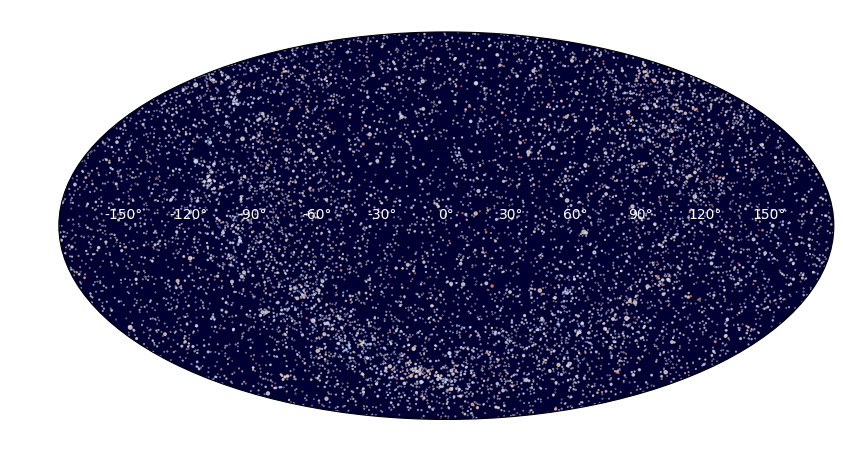

In [8]:
df = compute_star_properties_from_exoplanet(df, df_exoplanets.iloc[3501])
plot_smth(df["new_ra"], df["new_dec"], df["apparent_magnitude"], df["bp_rp"])


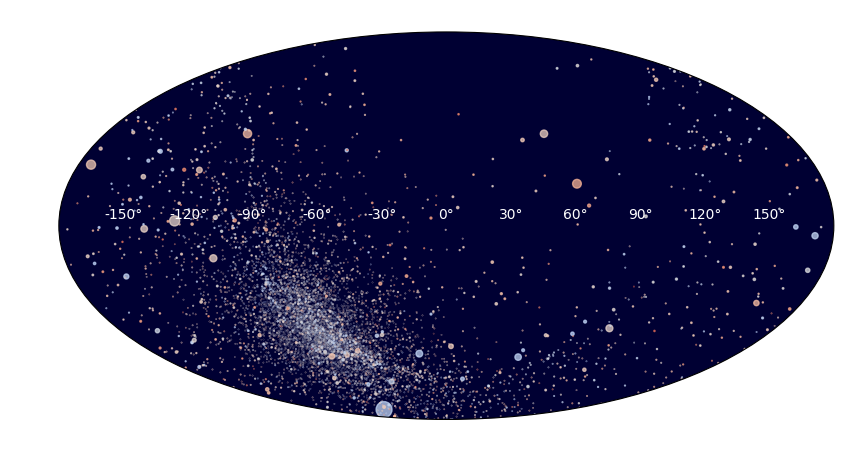

In [9]:
df = compute_star_properties_from_exoplanet(df, df_exoplanets.iloc[2])
plot_smth(df["new_ra"], df["new_dec"], df["apparent_magnitude"], df["bp_rp"])


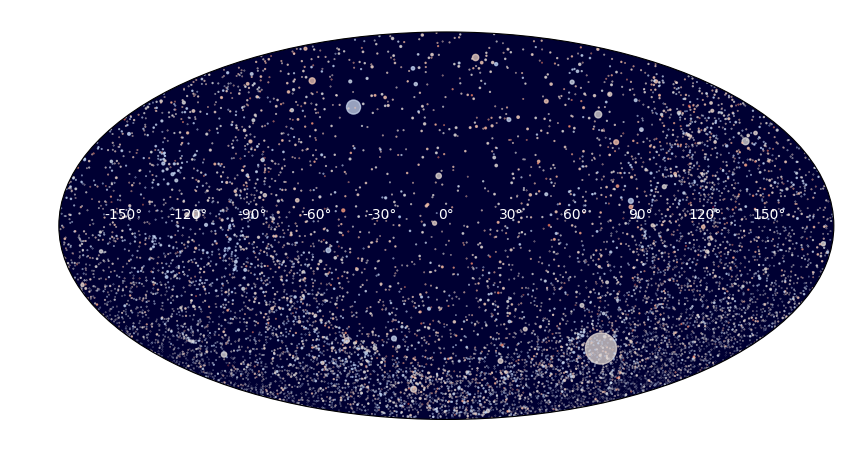

In [10]:
df = compute_star_properties_from_exoplanet(df, df_exoplanets.iloc[3])
plot_smth(df["new_ra"], df["new_dec"], df["apparent_magnitude"], df["bp_rp"])


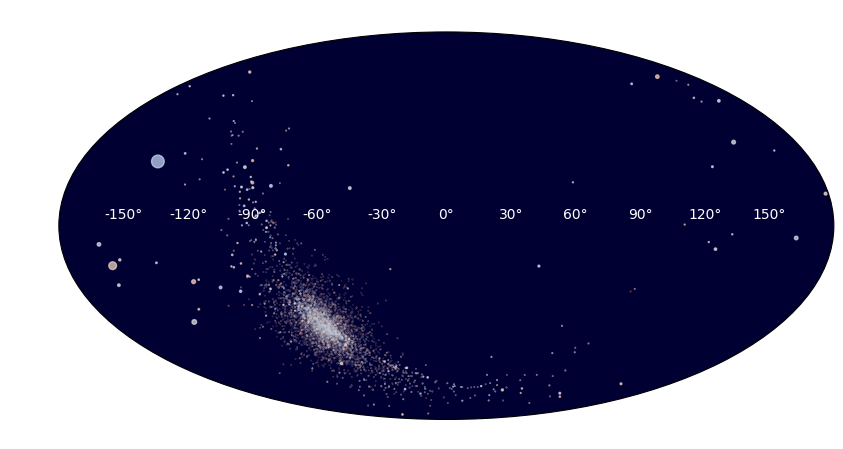

In [11]:
df = compute_star_properties_from_exoplanet(df, df_exoplanets.iloc[0])
plot_smth(df["new_ra"], df["new_dec"], df["apparent_magnitude"], df["bp_rp"])
